## What is Transfer Learning?

**Transfer Learning** is the process of using other model's weight and use them to solve our problem.

It's like a person explaining another person that has never seen a horse, what horse look like.

So the task is to find a **well-performed** existing model to help us solve our problem.

The **why** using Tranfer Learning is a stupid question. Of course, we should use transfer learning whenever is possible. 

`Dont be arrogant and want to reinvent the weel, grow up!`

## Where you can find pre-trained Models?

In general the deep-learning community is an **Open Source** community, so the model is widely accessed in the web. Some places are:
* PyTorch domain libraries (torchvision.models, torchtext.models, ...)
* HuggingFace Hub (https://huggingface.co/models)
* timm (PyTorch Image Models) library (https://github.com/rwightman/pytorch-image-models)
* Paperswithcode (https://paperswithcode.com/)

In [ ]:
# For this notebook to work we need torch, torchvision in versions 1.12+ and 0.13+

import torch
from torch import nn, optim
from torchvision import transforms, models

import matplotlib.pyplot as plt
from pathlib import Path

In [ ]:
!pip install -q torchinfo

In [ ]:
from torchinfo import summary # For visualizing our Model

In [ ]:
# Import from drive the modules for creating the DataLoaders and the Training/Evaluating Functions (`Going_Modular.ipynb`)
from drive.MyDrive.going_modular.going_modular import data_setup, engine

## Setting up Default Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device.type)

cpu


## Loading the Pre-Installed Dataset (on `Custom_Datasets.ipynb`)

In [ ]:
dataset_path = Path("/content/drive/MyDrive/going_modular/data/pizza_steak_sushi")

# Setting up the training and testing Paths
train_path = dataset_path / "train"
test_path = dataset_path / "test"

## Preparing the Dataset (Manual Creation)
When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

All pre-trained models in `torchvision.models` expect input images normalized in the same way:
* Mini-batches of 3-channel RGB images of shape: (3, H, W), where H,W at least 224
* he images have to be loaded in to a range of [0, 1]
* The have to be normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

There are some exceptions to that rule, so to be clear see documentation: https://pytorch.org/vision/0.8/models.html

-

Let's analyze `mean` and `std` a little more:
1. Its the mean and the standard deviation accross the `image channel`
2. These were calculated from the data
3. We also don't need to do this. Neural networks are usually quite capable of figuring out appropriate data distributions.

By setting them at the start can help our networks achieve better performance quicker.

In [ ]:
# Creating the above Transformations
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 244)),              # For resizing each image
    transforms.ToTensor(),                           # For reducing each value to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # For setting the mean and std values per channel
                         std=[0.229, 0.224, 0.225])
])

## Preparing the Dataset (Auto Creation)

Instead of manualy, figure the way to transform our Dataset so it can be compatable with the pre-trained Model, Pytorch generated those tranformations just by knowing the `model architecture`.

The architecture that out pre-trained Model is based on is `EfficientNet_B0_Weights`.

In [ ]:
# Getting the pre-trained Model's weights
weights = models.EfficientNet_B0_Weights.DEFAULT

print(weights)

EfficientNet_B0_Weights.IMAGENET1K_V1


`DEFAULT` means the best available weights (there are more options and much more architectures in the torchvision.models documentation)

In [ ]:
# Getting the best transformation for that Model Architecture
auto_transform = weights.transforms()

print(auto_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


By using `Auto Creation` we are creating the transforms much faster (and with no errors), but the downside is the lack of customization.

## Creating the DataLoaders (using `data_setup.create_dataloaders()`)

In [ ]:
BATCH_SIZE = 32

train_dl, test_dl, classes = data_setup.create_dataloaders(train_dir=train_path,
                                                           test_dir=test_path,
                                                           train_transform=auto_transform,
                                                           test_transform=auto_transform,
                                                           batch_size=BATCH_SIZE)

print(len(train_dl), len(test_dl))
print(classes)

8 3
['pizza', 'steak', 'sushi']


## Getting a Pre-Trained Model

In the official documentation there are a lot of architectures (models) that we can use such as:
* ResNet
* VGG
* EfficientNet
* VisionTransformer
* ConvNeXt

Depending of the problem and device we can use one of those models. Note that each model comes with a number at the end. The bigger the number the larger and more accurate the model is going to be.

The Model we are going to use is `torchvision.models.efficientnet_b0()`.
The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

In [ ]:
# To set the pre-trained model we need its weight, that we have calculated above
weights = models.EfficientNet_B0_Weights.DEFAULT

model = models.efficientnet_b0(weights=weights).to(device)

## Understanding the Model

By printing the Model (other than a lot of layers) we can see that comes in three main parts:
1. `features`: A collection of convolutional layers and other various activation layers to learn a base representation of vision data.
2. `avgpool`: Takes the average of the output of the features layer(s) and turns it into a feature vector.
3. `classifier`: Turns the feature vector into a vector with the same dimensionality as the number of required output classes.

In [ ]:
# We can use `torchinfo` to get the summary of the model
summary(model=model,
        input_size=(1, 3, 224, 224),                                        # the shape of the data we'd like to pass to our model
        col_names=["input_size", "output_size", "num_params", "trainable"], # the various information columns we'd like to see about our model
        col_width=20,                                                       # how wide the columns should be for the summary
        row_settings=["var_names"])                                         # what features to show in a row

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

## Freezing the Model

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called `classifier` layers) to suit your needs.

To freeze layers means to keep them how they are during training.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False

## Adjusting the Output Layers

The Pre-Trained Model comes with 1000 output size, we want to reduce it to just 3 (pizza, steak and sushi).

In [ ]:
# Get the length of class_names (one output unit for each class)
output_size = len(classes)

# Changing the `classifier` part to fit to our goals.
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),                # Keeping it as it is
    torch.nn.Linear(in_features=1280, 
                    out_features=output_size)).to(device) # same number of output units as our number of classes

In [ ]:
# Summarizing once again the model
summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

Note that `Trainable` set the feature parameters False.

## Train and Evaluating the Model (using `engine.fit()`)

In [ ]:
# Creating a Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3) # It is the default learning-rate of the Adam Opimizer

In [ ]:
# Training and Evaluating the Model
results = engine.fit(model=model,
                     epochs=5,
                     train_dl=train_dl,
                     valid_dl=test_dl,
                     loss_fn=loss_fn,
                     eval_metric=engine.accuracy_fn,
                     optim=opt)

Starting Process...


  0%|          | 0/5 [00:00<?, ?it/s]

-> Epoch: 1 | Train Loss: 1.0314 | Train Accuracy: 41.80% | Test Loss: 0.8879 | Test Evaluation (%): 67.05%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 2 | Train Loss: 0.8954 | Train Accuracy: 58.59% | Test Loss: 0.8114 | Test Evaluation (%): 70.27%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 3 | Train Loss: 0.7428 | Train Accuracy: 84.77% | Test Loss: 0.6661 | Test Evaluation (%): 84.47%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 4 | Train Loss: 0.7458 | Train Accuracy: 68.36% | Test Loss: 0.6125 | Test Evaluation (%): 87.50%
-----------------------------------------------------------------------------------------------------------
-> Epoch: 5 | Train Loss: 0.6391 | Train Accuracy: 75.78% | Test Loss: 0.6363 | Test Evaluation (%): 83.43%
----------------------------

## Plotting the Loss Curves

In [ ]:
def plot_loss_curve(model_res):
    plt.figure(figsize=(6, 4))

    plt.plot(range(model_res["model_epochs"]), model_res["model_valid_loss"], c='g', label="Test Loss")
    plt.plot(range(model_res["model_epochs"]), model_res["model_train_loss"], c='b', label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves: {model_res['model_name']}", fontsize=14)
    plt.legend(fontsize=11)

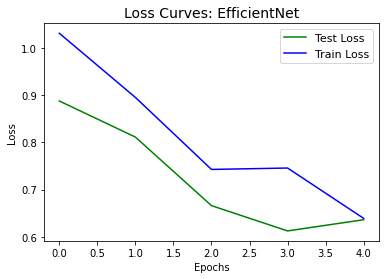

In [ ]:
plot_loss_curve(results)

## Making Predictions

In [ ]:
import requests

# Creating the new image path
new_image_path = dataset_path / "unseen_image.jpg"

# Downloading the image if it does not exists
if not new_image_path.is_file():
    with open(new_image_path, "wb") as f:
        req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
        print("Downloading Image...")
        f.write(req.content)
else:
    print(f"{new_image_path} already exists...")

In [ ]:
from torchvision.io import read_image

# Creating a Plotting Function
def get_prediction(model, label_names, image_path, transform):
    model_dtype = next(model.parameters()).dtype
    model_device = next(model.parameters()).device

    image_tensor = read_image(str(image_path)).type(model_dtype)
    norm_image_tensor = transform(image_tensor).to(model_device)

    model.eval()
    with torch.inference_mode():
        logits = model(norm_image_tensor.unsqueeze(dim=0))

    pred_label = label_names[torch.softmax(logits, dim=1).argmax(dim=1)]
    label_prob = torch.softmax(logits, dim=1).max().item() * 100

    plt.imshow(image_tensor.permute(1, 2, 0).cpu().type(torch.uint8))
    plt.title(f"Label: {pred_label} | Probability: {label_prob: .2f}%")
    plt.axis(False)

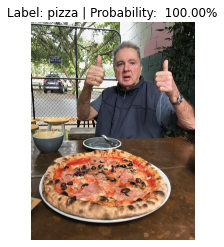

In [ ]:
get_prediction(model, classes, new_image_path, auto_transform)